In [12]:
import pandas as pd
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.base import clone
from rfpimp import plot_corr_heatmap, feature_dependence_matrix, plot_dependence_heatmap
from sklearn.model_selection import train_test_split

%matplotlib inline

In [13]:
df = pd.read_csv('/Users/ira/Downloads/REALEC_Inspector/data/feature_result.csv')
df = df[df['type'] != 4]
df['sum_punct'] = df[['punct_mistakes_pp', 'punct_mistakes_because',
                      'punct_mistakes_but', 'punct_mistakes_compare',]].sum(axis=1)
df = df.drop('side_mistake', axis=1)
df = df.drop('vs', axis=1)
df = df.drop('squared_vs', axis=1)
df = df.drop('ttr', axis=1)
df = df.drop('root_ttr', axis=1)
df = df.drop('log_ttr', axis=1)
df = df.drop('uber_ttr', axis=1)
df = df.drop('d', axis=1)
df = df.drop('vvi', axis=1)
df = df.drop('squared_vv', axis=1)
df = df.drop('punct_mistakes_pp', axis=1)
df = df.drop('punct_mistakes_because', axis=1)
df = df.drop('punct_mistakes_but', axis=1)
df = df.drop('punct_mistakes_compare', axis=1)
df = df.round(2)
df.head(3)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,name,text,class,type,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,1,0,0,2,0,./data/exam/exam2017/OBy_146_1,This two line graphs illustrates monthly avera...,60,1,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,1,0,0,3,0,./data/exam/exam2017/EGe_15_1,"﻿We have two graphics, which show us the popul...",65,1,0
2,3.81,6,0,5,0,13,16,292,4.56,18.25,...,5,2,1,1,0,./data/exam/exam2017/DOv_2_2,More and more young people are stunding on the...,60,2,1


In [14]:
df = df.drop('name', axis=1)
df = df.drop('text', axis=1)
df_1 = df[df['type'] == 1]
df_2 = df[df['type'] == 2]
df = df.drop('type', axis=1)
df_1 = df_1.drop('type', axis=1)
df_2 = df_2.drop('type', axis=1)

In [15]:
targets = []
for t in df['class']:
    if int(t) >= 70:
        targets.append('best')
    else:
        targets.append('not_best')
df['class'] = targets

In [16]:
column_features = list(df.columns)
column_features.remove('class')

In [17]:
base_rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=5, 
    n_jobs=-1,
    oob_score=True,
    class_weight='balanced')

# Sklearn feature importance

In [7]:
def plot_sklearn_feature_importance(df, base_rf):
    X_train, y_train = df.drop('class',axis=1), df['class']
    X_train['random'] = np.random.random(size=len(X_train))
    rf = clone(base_rf)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = [X_train.columns[i] for i in indices]
    fi_df = pd.DataFrame(data={'importance': importances[indices], 'feature': features})
    return fi_df

In [32]:
def plot_importance(df_importance):
    plt.figure(figsize=(15,8))
    sns_plt = sns.barplot(x="feature", y="importance", data=df_importance, palette="Set2")
    loc, labels = plt.xticks()
    sns_plt.set_xticklabels(labels, rotation=90)
    return sns_plt

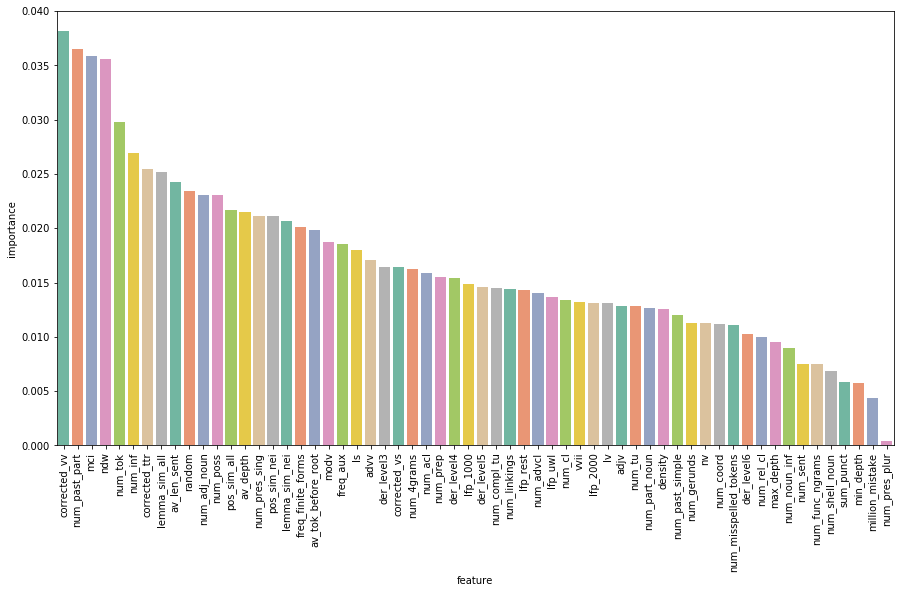

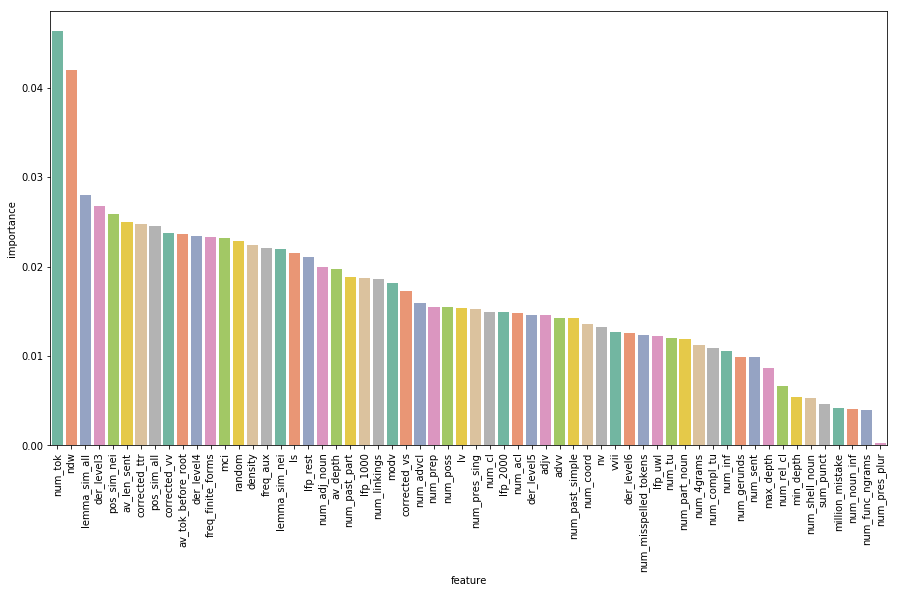

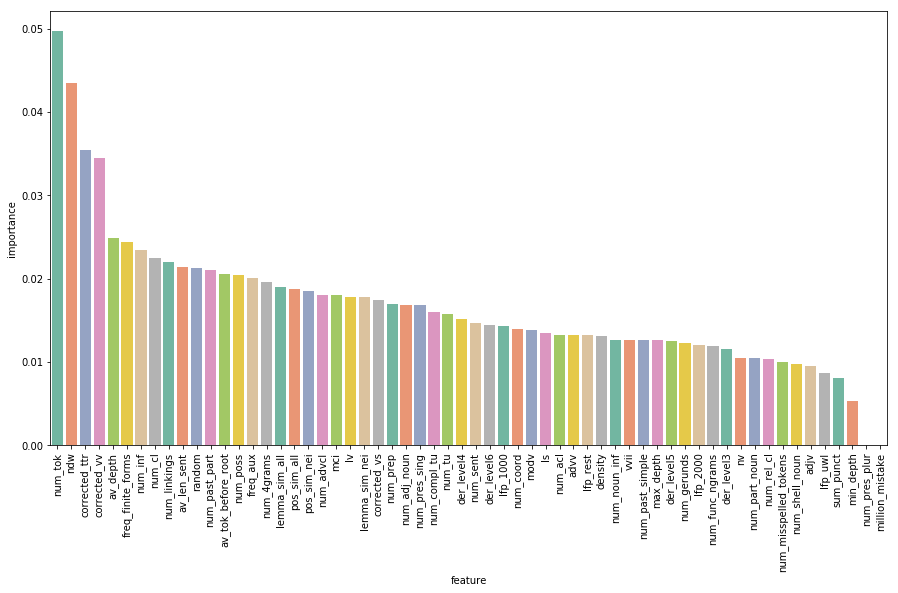

In [9]:
fi_df = plot_sklearn_feature_importance(df, base_rf)
sns_plt = plot_importance(fi_df)
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/importance/together/sklearn_feature_importance.png', bbox_inches = "tight")

fi_df = plot_sklearn_feature_importance(df_1, base_rf)
sns_plt = plot_importance(fi_df)
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/importance/type_1/sklearn_feature_importance.png', bbox_inches = "tight")

fi_df = plot_sklearn_feature_importance(df_2, base_rf)
sns_plt = plot_importance(fi_df)
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/importance/type_2/sklearn_feature_importance.png', bbox_inches = "tight")

# Permutation importance

In [10]:
def oob_classifier_accuracy(rf, X_train, y_train):
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    return oob_score

def permutation_importances(rf, X_train, y_train, metric):
    """
    Return importances from pre-fit rf; metric is function
    that measures accuracy or R^2 or similar. This function
    works for regressors and classifiers.
    """
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [11]:
def plot_permutation_feature_importance(df, base_rf):
    X_train, y_train = df.drop('class',axis=1), df['class']
    X_train['random'] = np.random.random(size=len(X_train))
    rf = clone(base_rf)
    rf.fit(X_train, y_train)
    importances = permutation_importances(rf, X_train, y_train, oob_classifier_accuracy)
    indices = np.argsort(importances)[::-1]
    features = [X_train.columns[i] for i in indices]
    fi_df = pd.DataFrame(data={'importance': importances[indices], 'feature': features})
    return fi_df

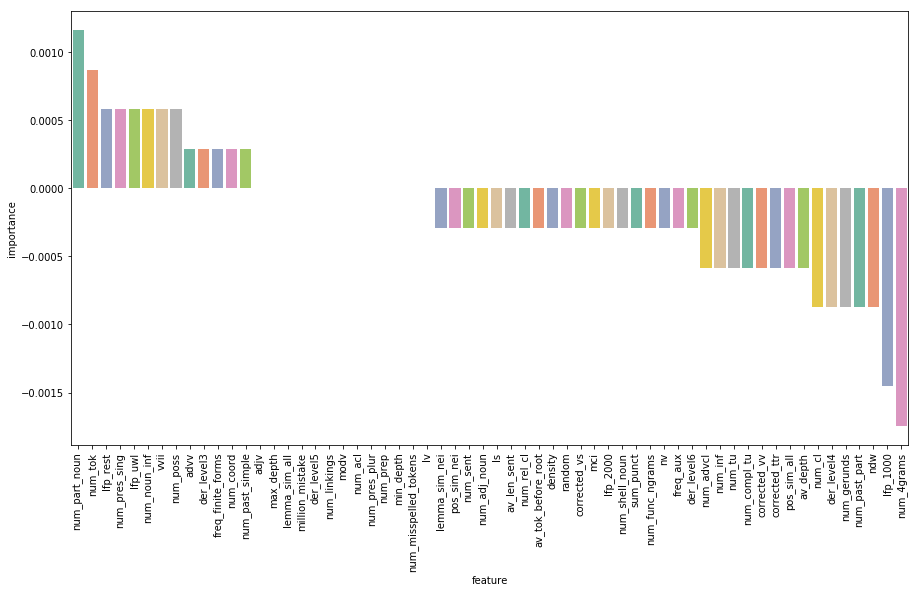

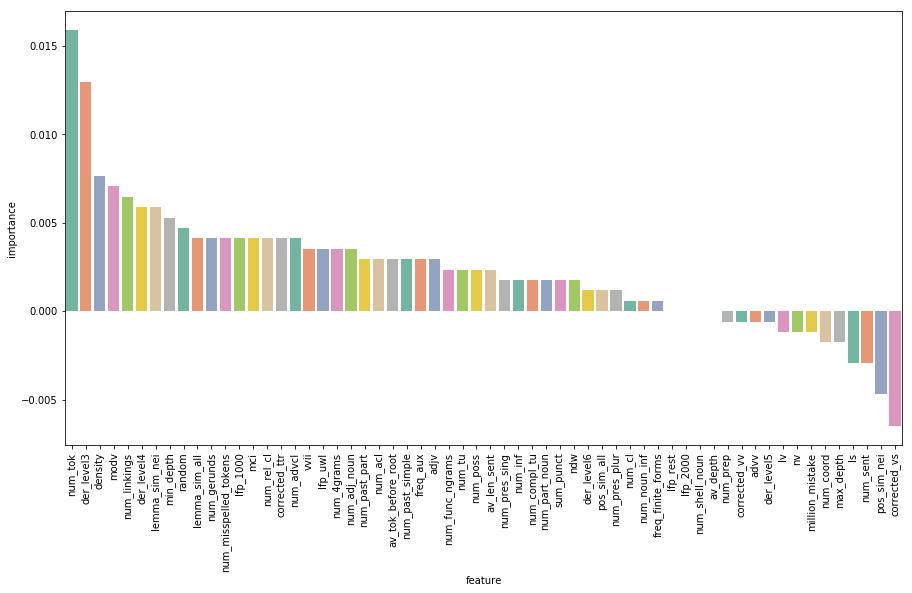

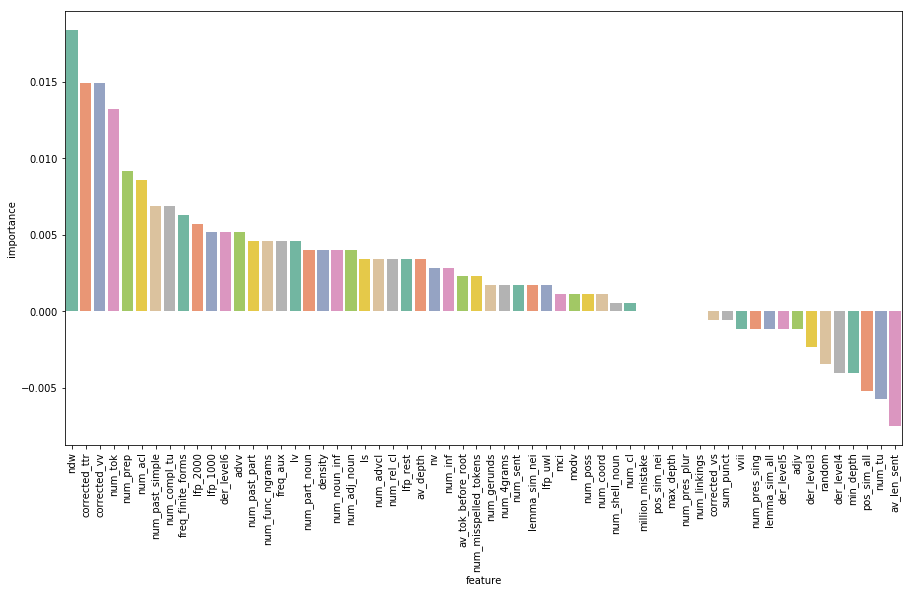

In [12]:
fi_df = plot_permutation_feature_importance(df, base_rf)
sns_plt = plot_importance(fi_df)
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/importance/together/permutation_feature_importance.png', bbox_inches = "tight")

fi_df = plot_permutation_feature_importance(df_1, base_rf)
sns_plt = plot_importance(fi_df)
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/importance/type_1/permutation_feature_importance.png', bbox_inches = "tight")

fi_df = plot_permutation_feature_importance(df_2, base_rf)
sns_plt = plot_importance(fi_df)
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/importance/type_2/permutation_feature_importance.png', bbox_inches = "tight")

# Drop-column importance

In [30]:
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    return np.array(imp)

def classifier_dropping_importances_cv(rf, X_train, y_train, k=5):
    rf_ = clone(rf)
    rf.random_state = 999
    rf_.fit(X_train, y_train)
    
    cvscore = cross_val_score(clone(rf), X_train, y_train, cv=k, scoring='accuracy')
    m_base = cvscore.mean()
    print(f"{k}-fold cross-validation accuracy {m_base:.4f}")
                              
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        
        cvscore = cross_val_score(clone(rf_), X, y_train, cv=5, scoring='accuracy')
        m = cvscore.mean()
        print(f"drop {col} {k}-fold cross-validation accuracy {m:.4f}")
        imp.append(m_base - m)
        
    return np.array(imp)

In [28]:
def plot_dropping_feature_importance(df, base_rf):
    X_train, y_train = df.drop('class',axis=1), df['class']
    X_train['random'] = np.random.random(size=len(X_train))
    rf = clone(base_rf)
    rf.fit(X_train, y_train)
    importances = dropcol_importances(rf, X_train, y_train)
    indices = np.argsort(importances)[::-1]
    features = [X_train.columns[i] for i in indices]
    fi_df = pd.DataFrame(data={'importance': importances[indices], 'feature': features})
    return fi_df

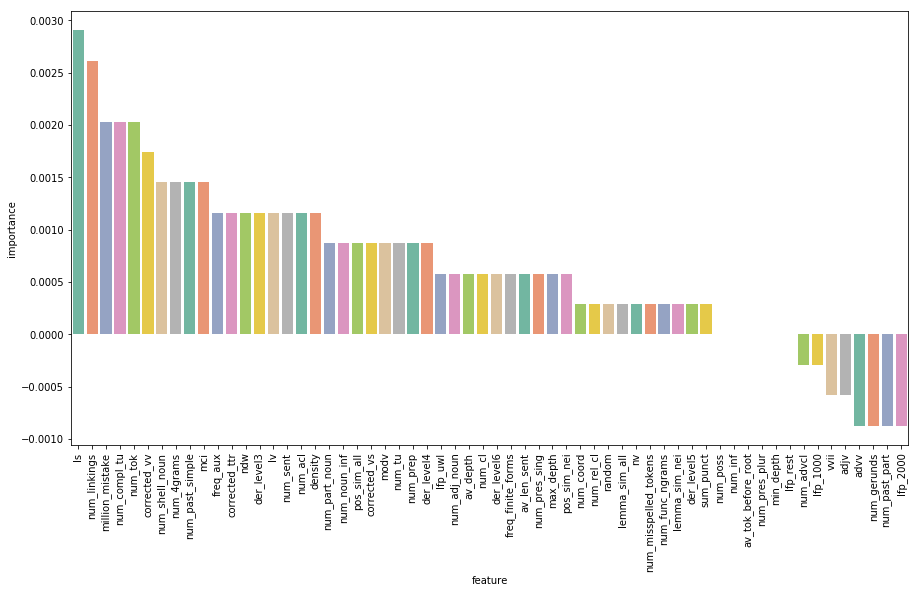

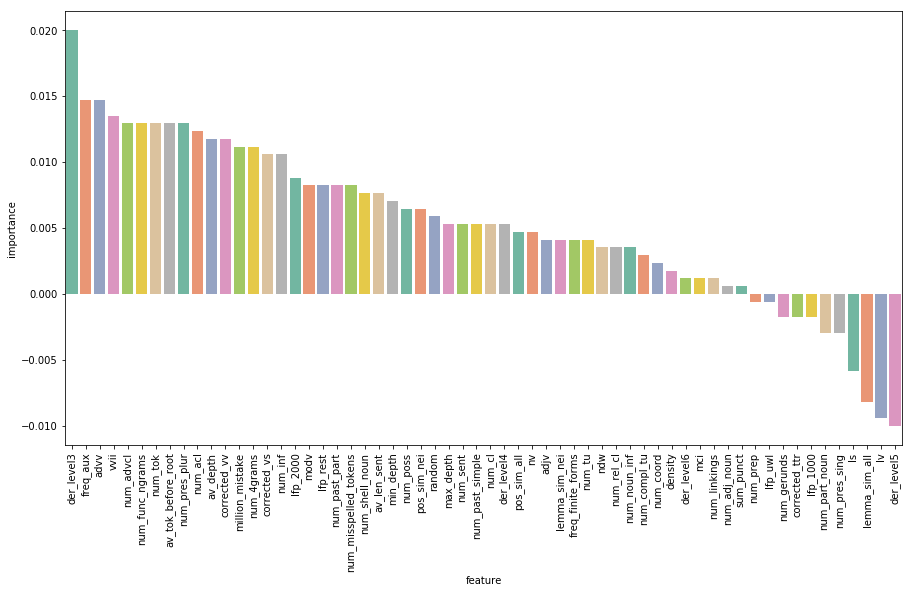

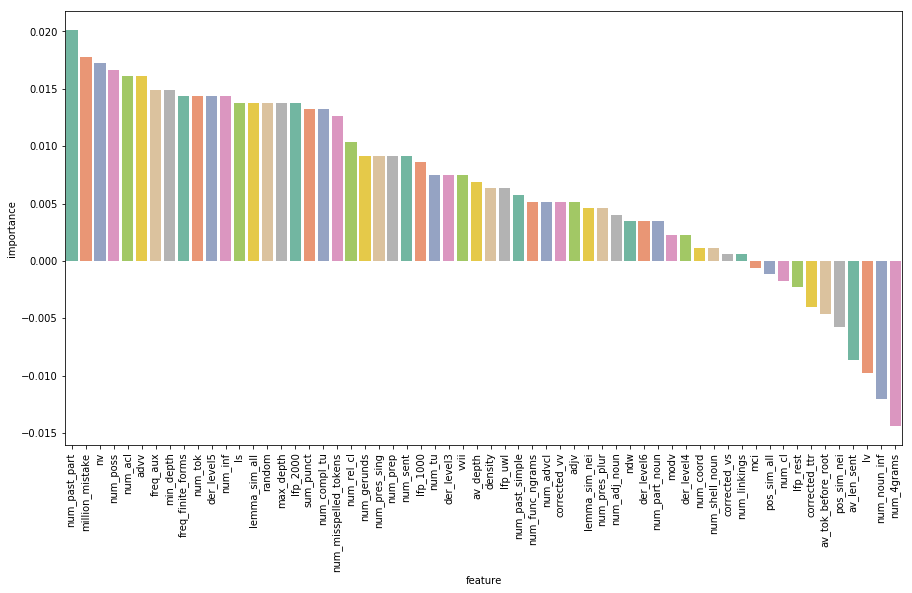

In [15]:
fi_df = plot_dropping_feature_importance(df, base_rf)
sns_plt = plot_importance(fi_df)
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/importance/together/dropping_feature_importance.png', bbox_inches = "tight")

fi_df = plot_dropping_feature_importance(df_1, base_rf)
sns_plt = plot_importance(fi_df)
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/importance/type_1/dropping_feature_importance.png', bbox_inches = "tight")

fi_df = plot_dropping_feature_importance(df_2, base_rf)
sns_plt = plot_importance(fi_df)
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/importance/type_2/dropping_feature_importance.png', bbox_inches = "tight")

# Collinearity

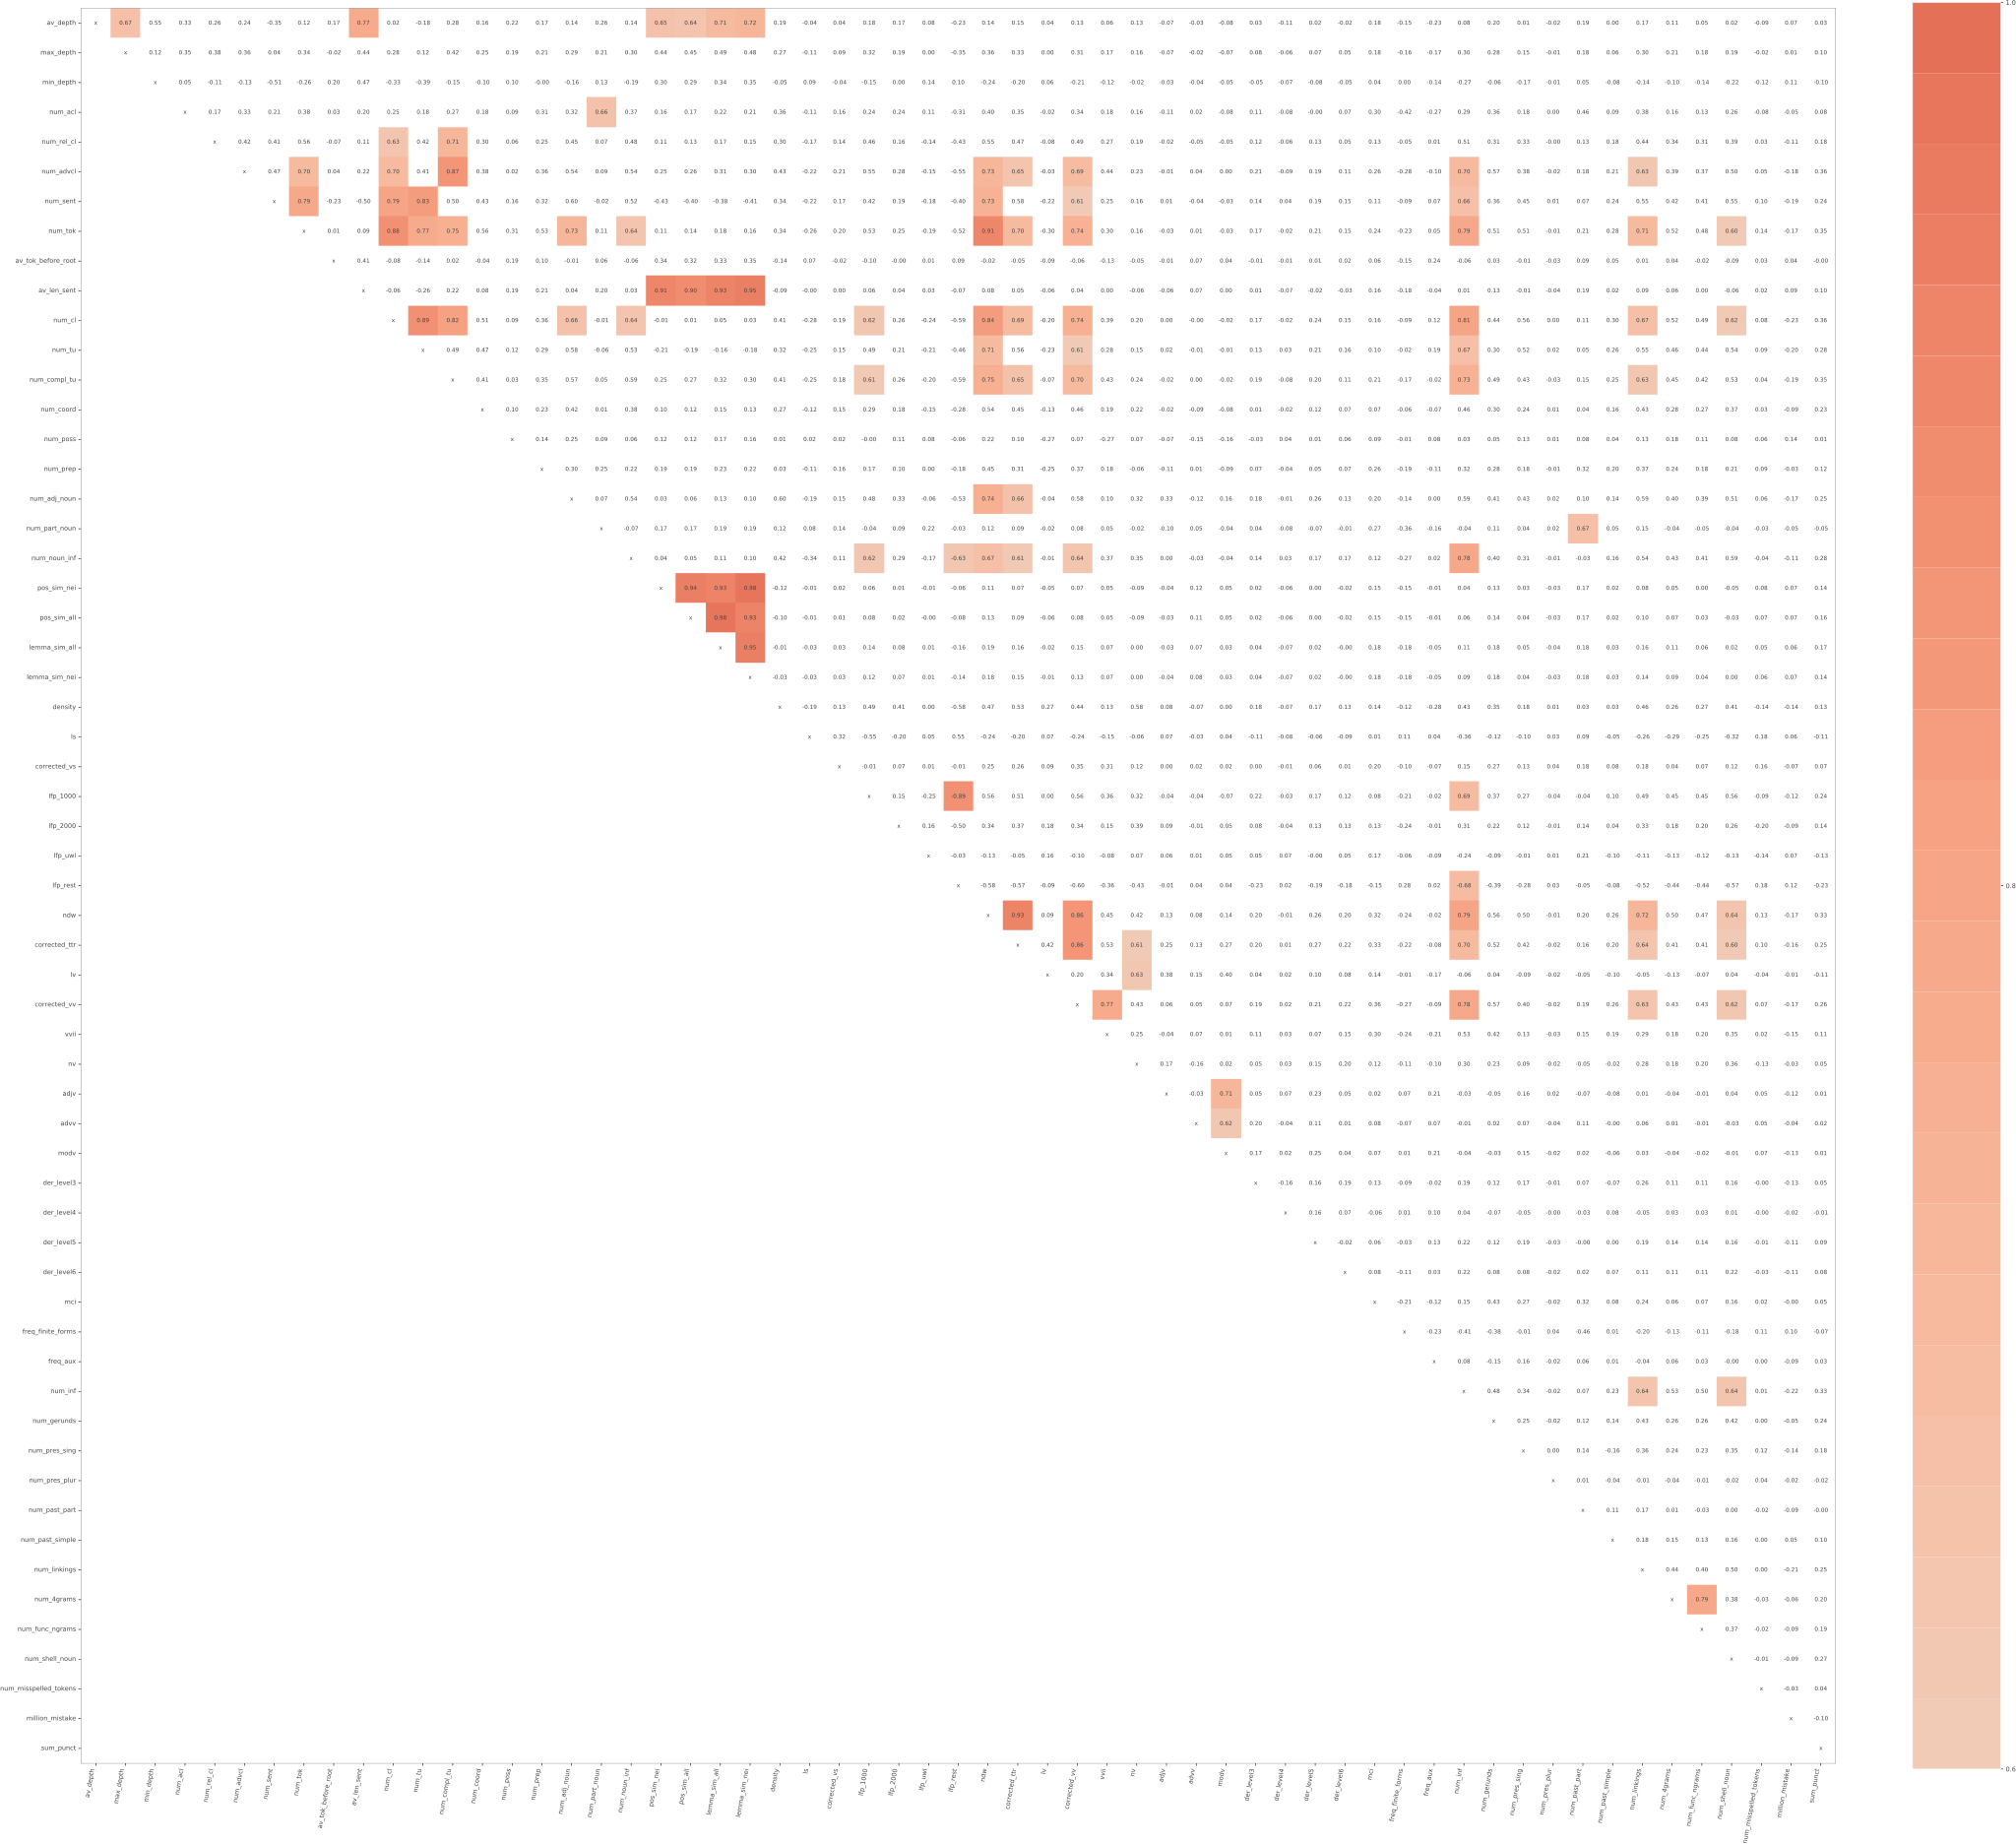

In [16]:
X_train, y_train = df.drop('class',axis=1), df['class']
viz = plot_corr_heatmap(X_train, figsize=(40, 40))
viz.save('/Users/ira/Downloads/REALEC_Inspector/graphs/collinearity/collinearity.svg')
viz

In [17]:
pd.set_option('precision', 3)
D = feature_dependence_matrix(X_train, sort_by_dependence=True)
D.columns

Index(['Dependence', 'av_depth', 'max_depth', 'min_depth', 'num_acl',
       'num_rel_cl', 'num_advcl', 'num_sent', 'num_tok', 'av_tok_before_root',
       'av_len_sent', 'num_cl', 'num_tu', 'num_compl_tu', 'num_coord',
       'num_poss', 'num_prep', 'num_adj_noun', 'num_part_noun', 'num_noun_inf',
       'pos_sim_nei', 'pos_sim_all', 'lemma_sim_all', 'lemma_sim_nei',
       'density', 'ls', 'corrected_vs', 'lfp_1000', 'lfp_2000', 'lfp_uwl',
       'lfp_rest', 'ndw', 'corrected_ttr', 'lv', 'corrected_vv', 'vvii', 'nv',
       'adjv', 'advv', 'modv', 'der_level3', 'der_level4', 'der_level5',
       'der_level6', 'mci', 'freq_finite_forms', 'freq_aux', 'num_inf',
       'num_gerunds', 'num_pres_sing', 'num_pres_plur', 'num_past_part',
       'num_past_simple', 'num_linkings', 'num_4grams', 'num_func_ngrams',
       'num_shell_noun', 'num_misspelled_tokens', 'million_mistake',
       'sum_punct'],
      dtype='object')

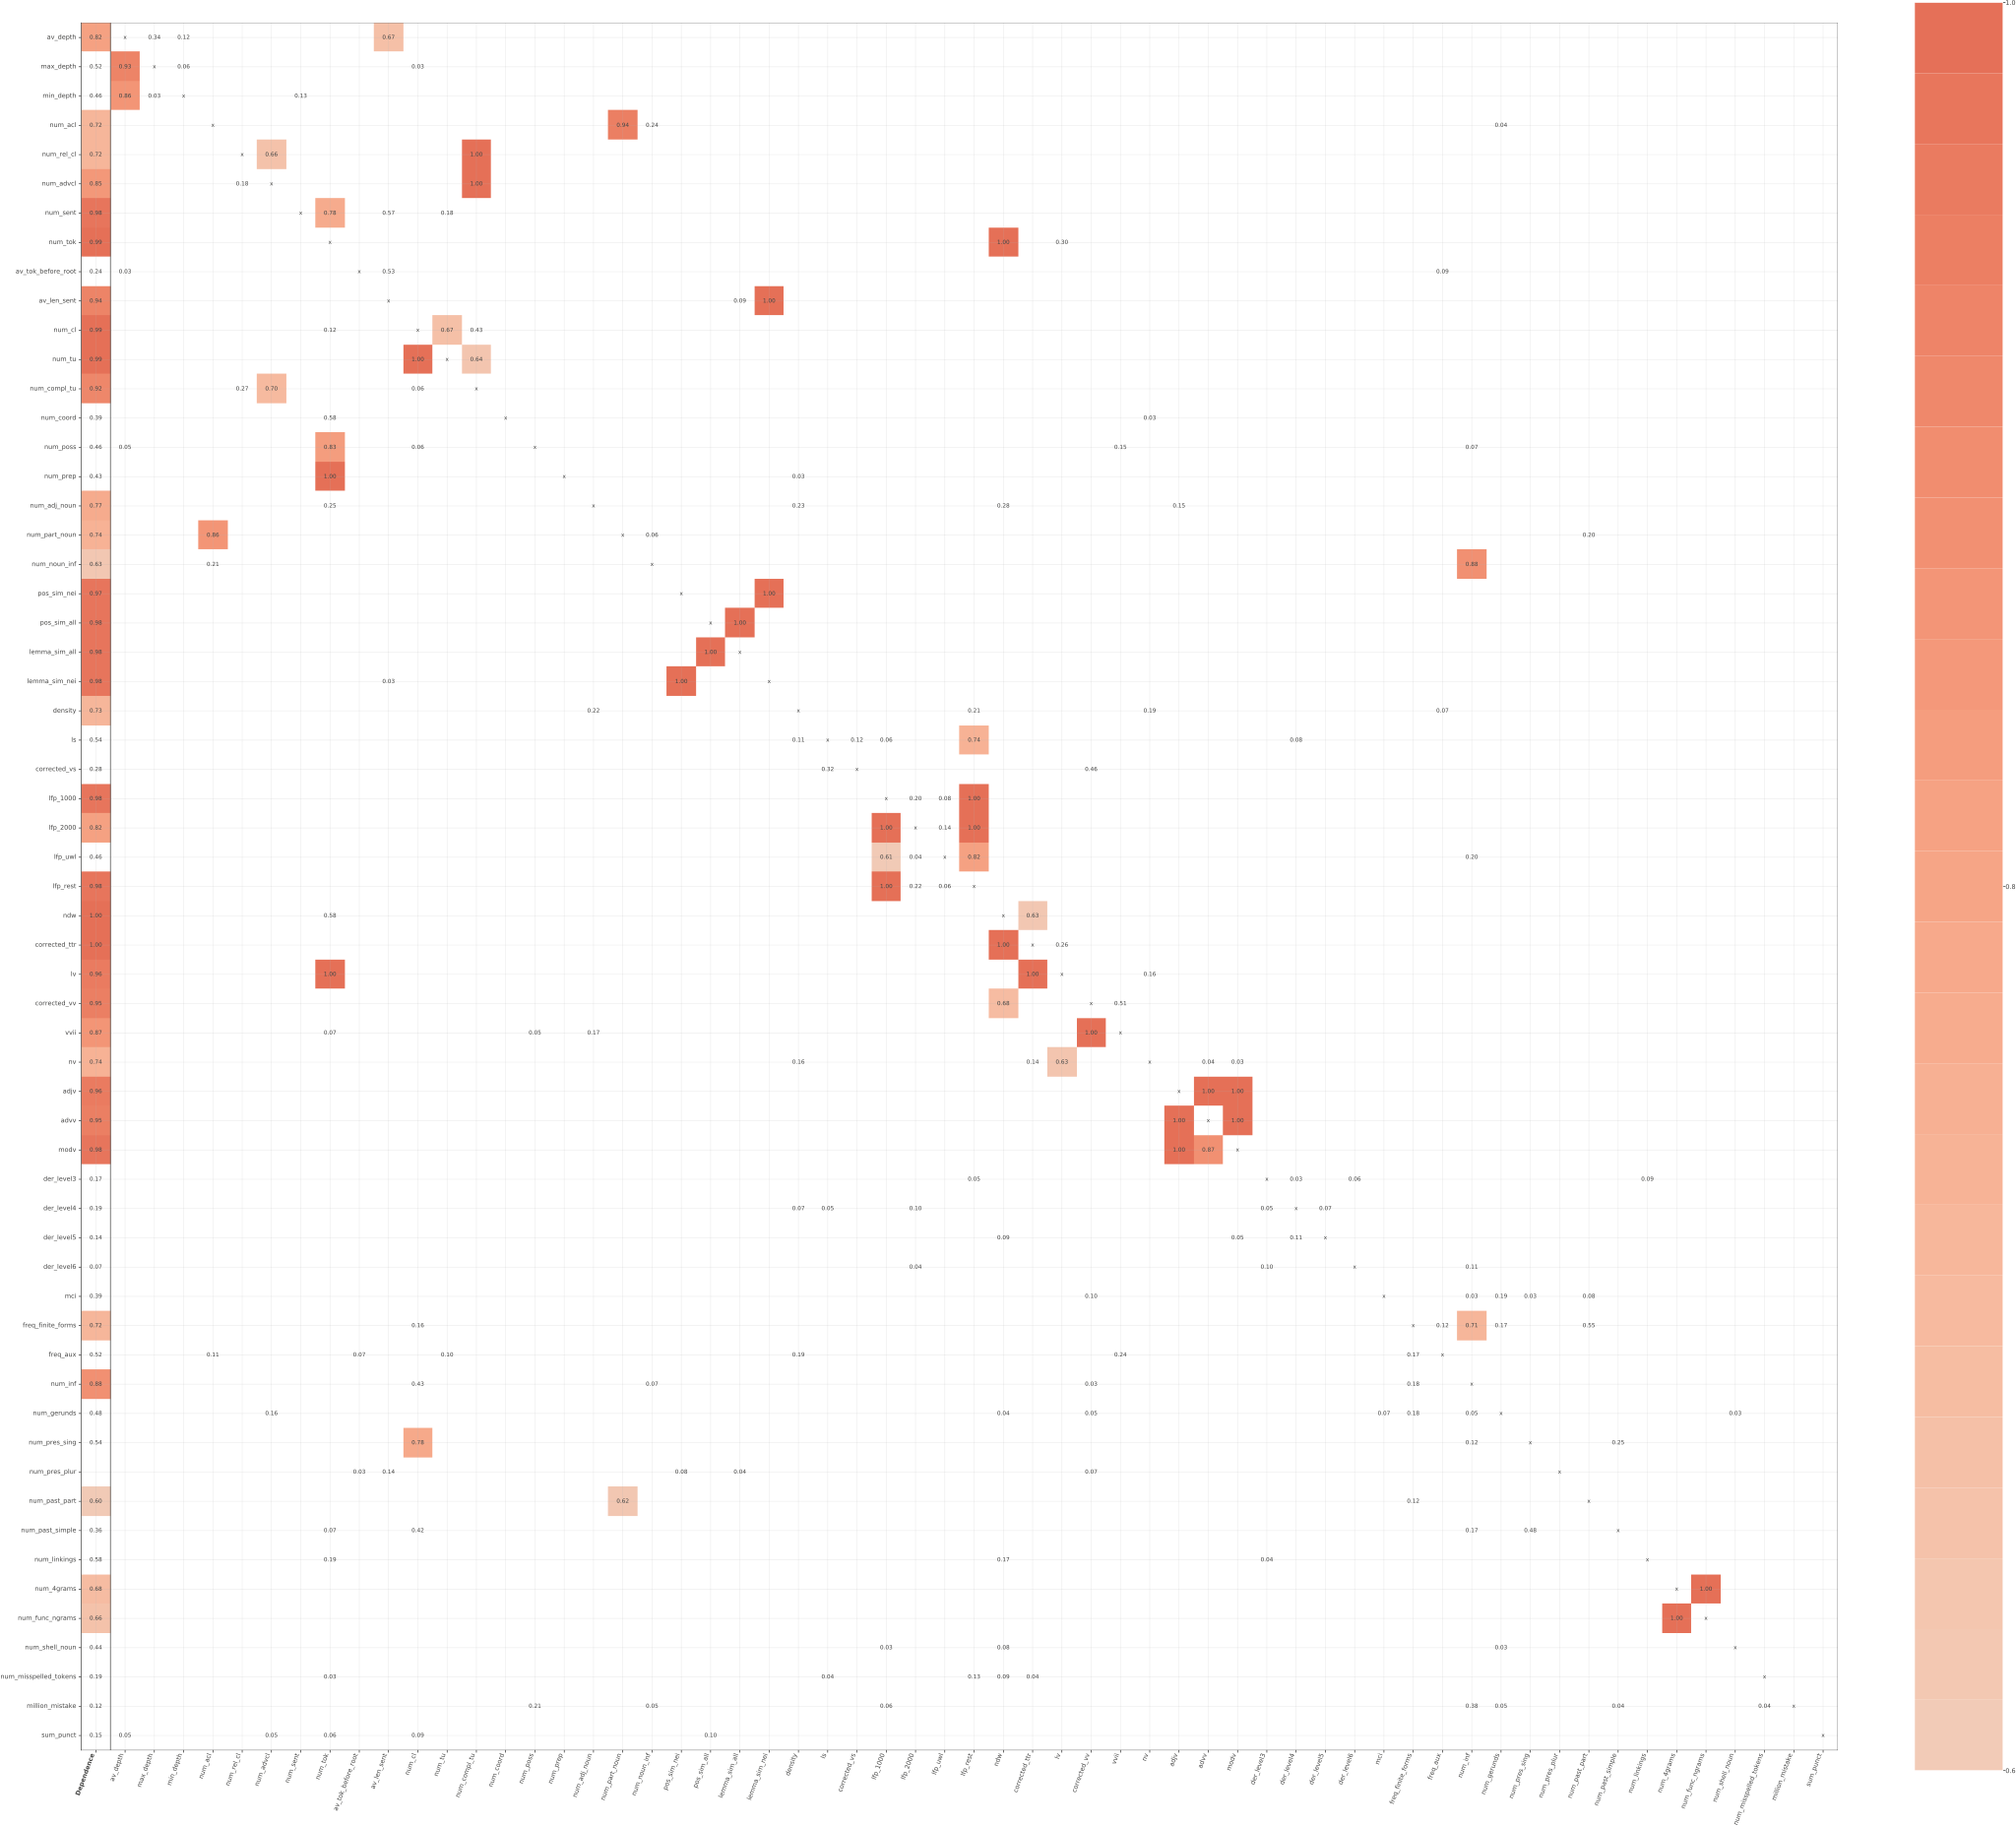

In [18]:
D = feature_dependence_matrix(X_train)
viz = plot_dependence_heatmap(D, figsize=(40,40))
viz.save('/Users/ira/Downloads/REALEC_Inspector/graphs/collinearity/feature_dependence_matrix_full.svg')
viz

# Predict on full

In [7]:
def predict_full(df):
    column_features = df.columns.tolist()
    column_features.remove('class')
    X = df[column_features]
    y = df['class']
    df = pd.DataFrame(X, columns=column_features)

    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.15)

    cl = RandomForestClassifier(n_estimators=100, oob_score=True, class_weight='balanced')
    cl.fit(X_train, y_train)
    print('OOB score:', cl.oob_score_)
    print('Accuracy:', cl.score(X_test, y_test))
    return X_train

In [12]:
X_train = predict_full(df)

OOB score: 0.8915868673050615
Accuracy: 0.9032882011605415


In [13]:
X_train = predict_full(df_1)

OOB score: 0.37257617728531855
Accuracy: 0.396078431372549


In [14]:
X_train = predict_full(df_2)

OOB score: 0.3844594594594595
Accuracy: 0.42748091603053434


# Predict on cut

In [18]:
def delete_columns(list_features, df):
    column_features = df.columns.tolist()
    column_features.remove('class')
    X = df[column_features]
    y = df['class']
    df = pd.DataFrame(X, columns=column_features)
    for f in list_features:
        df = df.drop(f, axis=1)
    df['class'] = y
    return df

In [19]:
list_features = ['num_prep', 'lv', 'num_tu', 'num_rel_cl',
                 'num_advcl', 'pos_sim_nei', 'pos_sim_all',
                 'lemma_sim_all', 'lfp_2000', 'lfp_rest',
                 'num_tok', 'corrected_ttr', 'vvii', 'adjv',
                 'advv', 'num_4grams']
df = delete_columns(list_features, df)
df_1 = delete_columns(list_features, df_1)
df_2 = delete_columns(list_features, df_2)

In [23]:
X_train = predict_full(df)

OOB score: 0.8909028727770177
Accuracy: 0.8858800773694391


In [21]:
X_train = predict_full(df_1)

OOB score: 0.38573407202216065
Accuracy: 0.4


In [22]:
X_train = predict_full(df_2)

OOB score: 0.39256756756756755
Accuracy: 0.4312977099236641


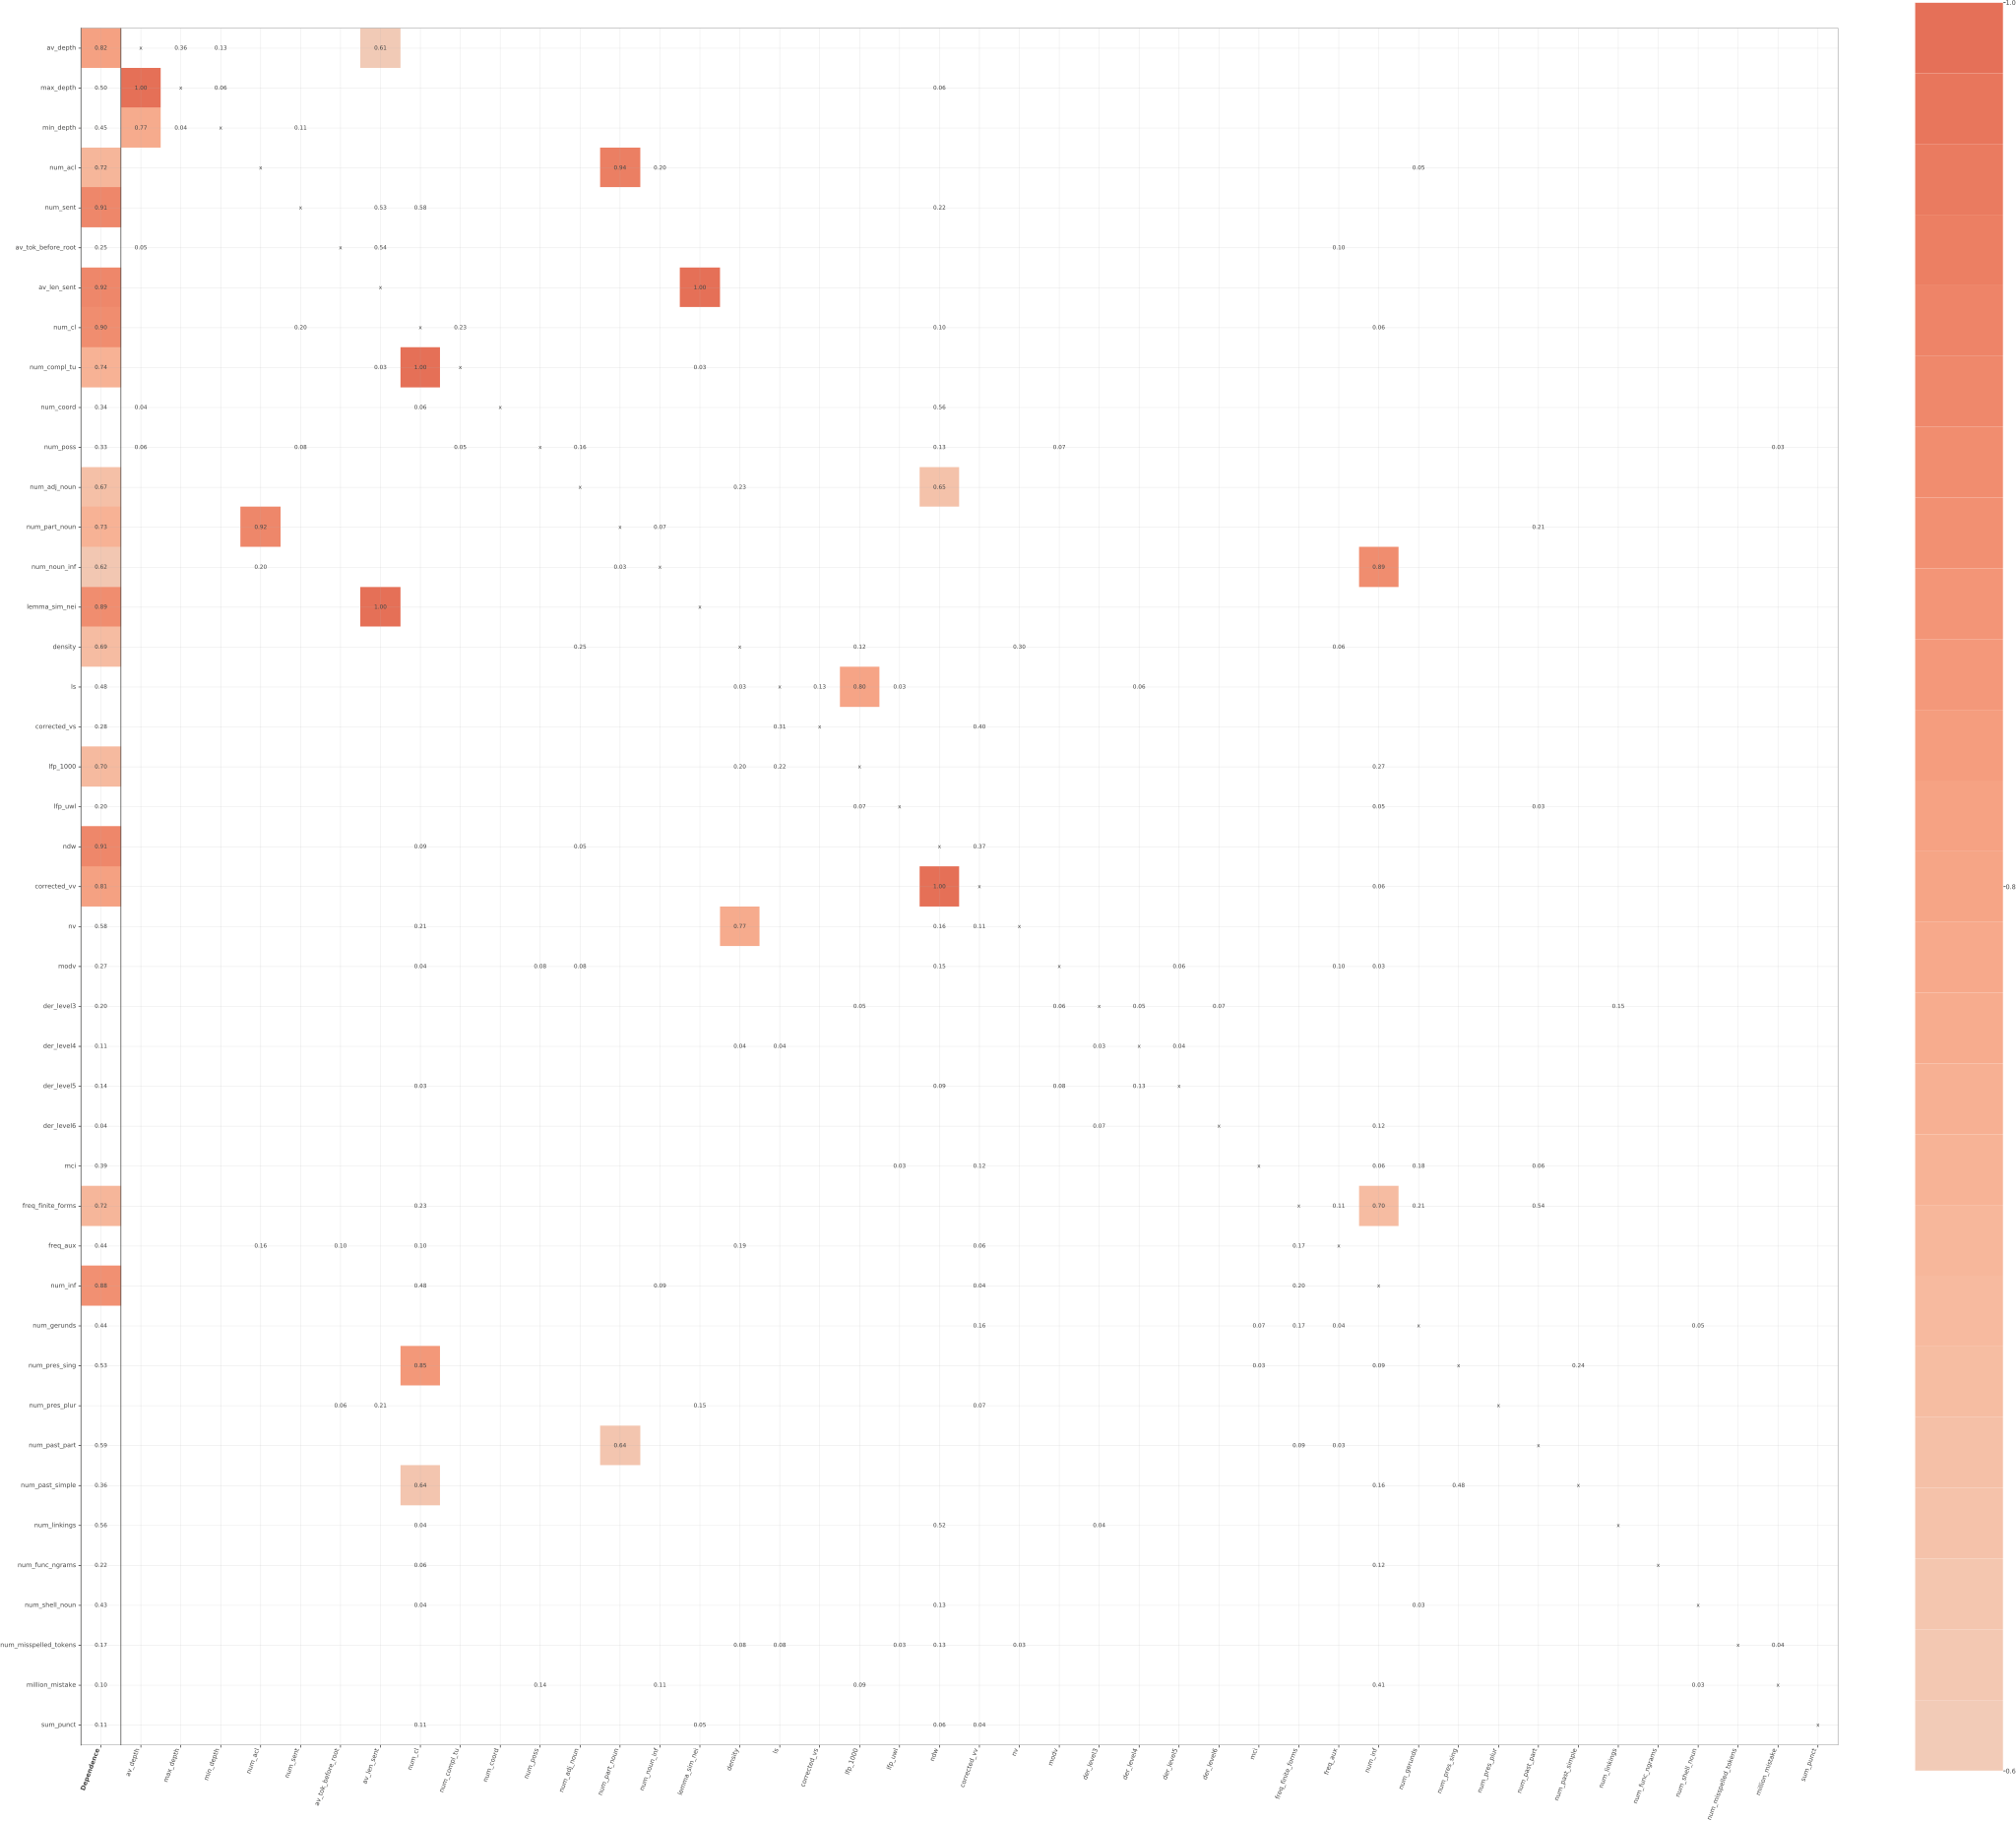

In [26]:
D = feature_dependence_matrix(X_train)
viz = plot_dependence_heatmap(D, figsize=(40,40))
viz.save('/Users/ira/Downloads/REALEC_Inspector/graphs/collinearity/feature_dependence_matrix_cut.svg')
viz

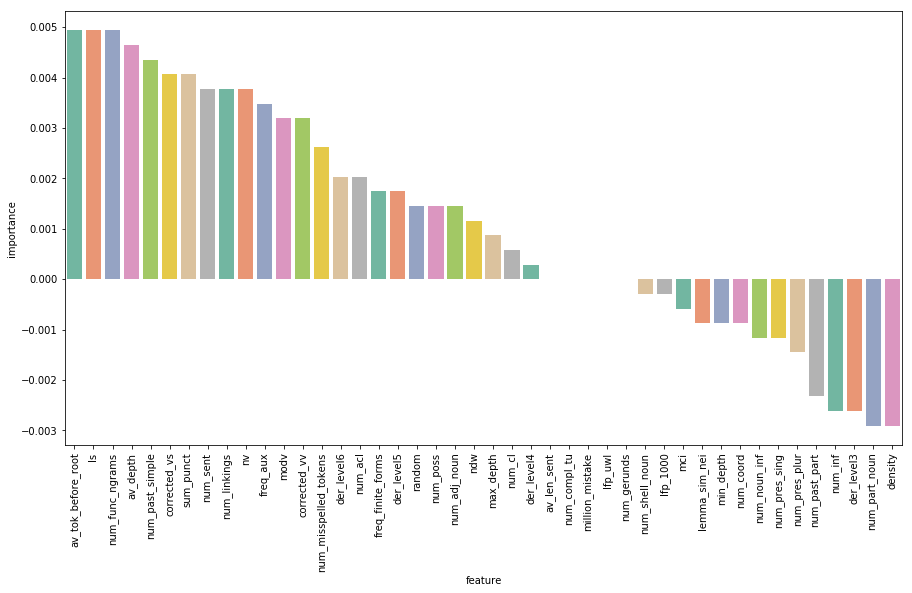

In [33]:
fi_df = plot_dropping_feature_importance(df, base_rf)
sns_plt = plot_importance(fi_df)
sns_plt.figure.savefig('/Users/ira/Downloads/REALEC_Inspector/graphs/collinearity/dropping_feature_importance_decrease_collinearity.png', bbox_inches = "tight")